# Question 1

## Question 1.1

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.sparse.linalg as ll
import pandas as pd
import scipy.io
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import confusion_matrix
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import cm as cm

In [2]:
data = scipy.io.loadmat('data/data.mat')['data']
label = scipy.io.loadmat('data/label.mat')['trueLabel']

data = np.array(data).T # each row is a data point 
label = np.array(label)

mu_original = np.mean(data, axis = 0, keepdims = True)
ndata = data - mu_original # shape = (784,1990)

m, n = ndata.shape
C = np.matmul(ndata.T, ndata)/m

# pca the data
d = 4  # reduced dimension
V,Gamma,_ = np.linalg.svd(C)
V = V[:, :d]
Gamma = np.diag(Gamma[:d])

# project the data to the top 2 principal directions
y = label
pdata = np.dot(ndata,V)

In [3]:
# ISyE 6740 Module 7 Demo Code 
K = 2

# random seed
seed = 5

# initialize prior
np.random.seed(seed)
pi = np.random.random(K)
pi = pi/np.sum(pi)

# initial mean and covariance
# np.random.seed(seed)
mu = np.random.randn(K,d)
mu_old = mu.copy()

sigma = []
for ii in range(K):
    # to ensure the covariance psd
    seed = 1 if ii == 0 else 4
    np.random.seed(seed)
    dummy = np.random.randn(d, d)
    sigma.append(dummy@dummy.T + np.eye(d))
    
# initialize the posterior
tau = np.full((m, K), fill_value=0.)

# # parameter for countour plot
xrange = np.arange(-5, -5, 0.1)
yrange = np.arange(-5, -5, 0.1)

maxIter = 100
tol = 1e-3

# plt.ion()
log_likelihood = []    
for ii in range(100):

    # E-step    
    for kk in range(K):
        sigma_det = np.linalg.det(sigma[kk])
        # print(sigma_det)
        tau[:, kk] = pi[kk] * mvn.pdf(pdata, mu[kk], sigma[kk])
        # print(tau[:,kk])
    # normalize tau
    sum_tau = np.sum(tau, axis=1)
    sum_tau.shape = (m,1)    
    tau = np.divide(tau, np.tile(sum_tau, (1, K)))
     
    log_likelihood.append(np.sum(np.log(sum_tau)))
    
    # M-step
    for kk in range(K):
        # update prior
        pi[kk] = np.sum(tau[:, kk])/m
        
        # update component mean
        mu[kk] = pdata.T @ tau[:,kk] / np.sum(tau[:,kk], axis = 0)
        
        # update cov matrix
        dummy = pdata - np.tile(mu[kk], (m,1)) # X-mu
        sigma[kk] = dummy.T @ np.diag(tau[:,kk]) @ dummy / np.sum(tau[:,kk], axis = 0)
        
    # print('-----iteration---',ii)  
    # tau_color = np.hstack((tau,np.ones((m,1))))  
    # plt.scatter(pdata[:,0], pdata[:,1], c= tau_color)
    # plt.axis('scaled')
    # plt.draw()
    # plt.pause(0.1)

    if np.linalg.norm(mu-mu_old) < tol:
        print('training coverged')
        break
    mu_old = mu.copy()
    if ii==99:
        print('max iteration reached')
        break

training coverged


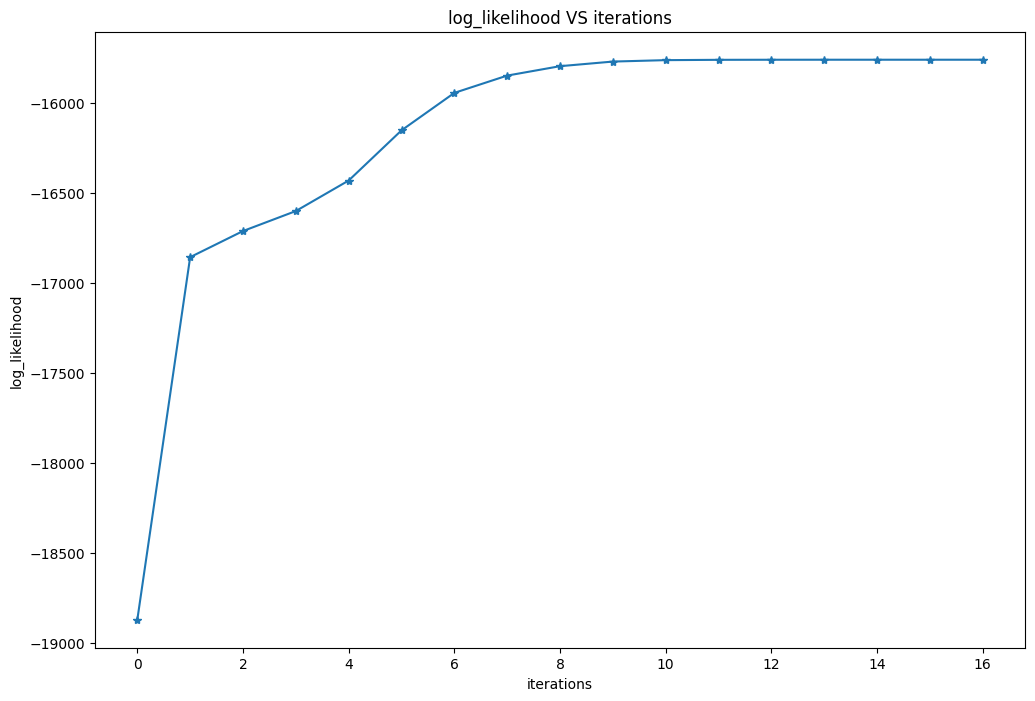

In [4]:
plt.figure(figsize = (12,8))
plt.plot(log_likelihood,'-*')
plt.title('log_likelihood VS iterations')
plt.ylabel('log_likelihood')
plt.xlabel('iterations')

plt.show()

## Question 1.2

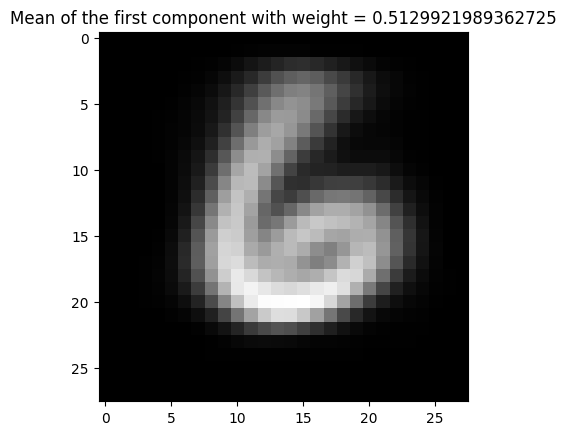

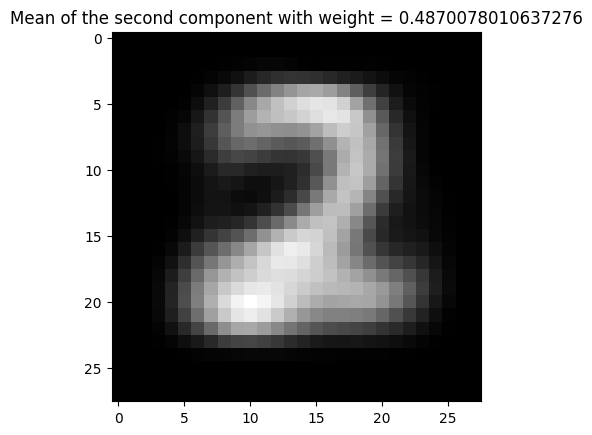

In [5]:

first_mean = (V @ mu[0] + mu_original).reshape((28,28)).T
plt.imshow(first_mean, cmap = 'gray')
plt.title('Mean of the first component with weight = ' + str(pi[0]))

plt.show()

second_mean = (V @ mu[1] + mu_original).reshape((28,28)).T
plt.imshow(second_mean, cmap = 'gray')
plt.title('Mean of the second component with weight = ' + str(pi[1]))

plt.show()

/var/folders/5m/thz32d2s4x50mxyp7fxy_3sw0000gn/T/ipykernel_29295/2827967030.py:3: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('Blues')


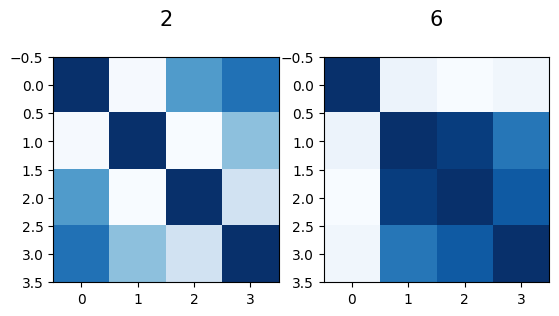

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

cmap = cm.get_cmap('Blues')
V1 = V @ sigma[0]
V2 = V @ sigma[1]
df0 = pd.DataFrame(V1)
df1 = pd.DataFrame(V2)


cax1 = ax1.imshow(df0.corr(), interpolation="nearest", cmap=cmap)
ax1.set_title('2\n',fontsize=15)


cax2 = ax2.imshow(df1.corr(), interpolation="nearest", cmap=cmap)
ax2.set_title('6\n',fontsize=15)

plt.show()

## Question 1.3

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.stats import multivariate_normal as mvn
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.cluster import KMeans
import pandas as pd
from scipy.optimize import linear_sum_assignment

In [8]:
# Load data and labels
data = scipy.io.loadmat('data/data.mat')['data']
label = scipy.io.loadmat('data/label.mat')['trueLabel'].flatten()

# Verify data and labels
print(f"Data shape: {data.shape}")
print(f"Label shape: {label.shape}")
print(f"Unique labels: {np.unique(label)}")

data = np.array(data).T  # each row is a data point
mu_original = np.mean(data, axis=0, keepdims=True)
ndata = data - mu_original  # shape = (1990, 784)

# Verify mean and centered data
print(f"Original mean shape: {mu_original.shape}")
print(f"Centered data shape: {ndata.shape}")

Data shape: (784, 1990)
Label shape: (1990,)
Unique labels: [2 6]
Original mean shape: (1, 784)
Centered data shape: (1990, 784)


In [9]:
# PCA transformation
m, n = ndata.shape
C = np.matmul(ndata.T, ndata) / m
d = 4  # reduced dimension
V, _, _ = np.linalg.svd(C)
V = V[:, :d]
pdata = np.dot(ndata, V)

# Verify PCA results
print(f"PCA transformed data shape: {pdata.shape}")

PCA transformed data shape: (1990, 4)


In [10]:
# Initialize parameters for EM algorithm
np.random.seed(0)
k = 2  # number of components
mu = np.random.randn(k, d)
sigma = [np.cov(pdata.T) for _ in range(k)]
pi = np.ones(k) / k
log_likelihood = []

# EM algorithm functions
def e_step(pdata, mu, sigma, pi, k):
    n = pdata.shape[0]
    r = np.zeros((n, k))
    for i in range(k):
        r[:, i] = pi[i] * mvn.pdf(pdata, mu[i], sigma[i])
    r = r / r.sum(axis=1, keepdims=True)
    return r

def m_step(pdata, r, k):
    n, d = pdata.shape
    mu = np.zeros((k, d))
    sigma = []
    pi = np.zeros(k)
    
    for i in range(k):
        r_i = r[:, i]
        total_r_i = r_i.sum()
        mu[i] = (r_i[:, np.newaxis] * pdata).sum(axis=0) / total_r_i
        sigma_i = (r_i[:, np.newaxis] * (pdata - mu[i])).T @ (pdata - mu[i]) / total_r_i
        sigma.append(sigma_i + np.eye(d) * 1e-6)  # Adding small value to diagonal for numerical stability
        pi[i] = total_r_i / n
    
    return mu, sigma, pi

def compute_log_likelihood(pdata, mu, sigma, pi, k):
    n = pdata.shape[0]
    log_likelihood = 0
    for i in range(k):
        log_likelihood += np.sum(np.log(pi[i] * mvn.pdf(pdata, mu[i], sigma[i])))
    return log_likelihood

# Run EM algorithm
max_iter = 100
tol = 1e-4
for i in range(max_iter):
    r = e_step(pdata, mu, sigma, pi, k)
    mu, sigma, pi = m_step(pdata, r, k)
    log_likelihood.append(compute_log_likelihood(pdata, mu, sigma, pi, k))
    
    if i > 0 and abs(log_likelihood[-1] - log_likelihood[-2]) < tol:
        break


In [11]:
# Verify final parameters and log-likelihood
print(f"Final log-likelihood: {log_likelihood[-1]}")
print(f"Final means: {mu}")
print(f"Final weights: {pi}")

Final log-likelihood: -55295.29398562372
Final means: [[ 1.99352444  0.57405894  0.11352725 -0.02386513]
 [-2.10086131 -0.60496786 -0.11963987  0.02515009]]
Final weights: [0.51310781 0.48689219]


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


             '2'      '6'
GMM      6.4922%  0.9395%
K-means  6.1047%  7.9332%


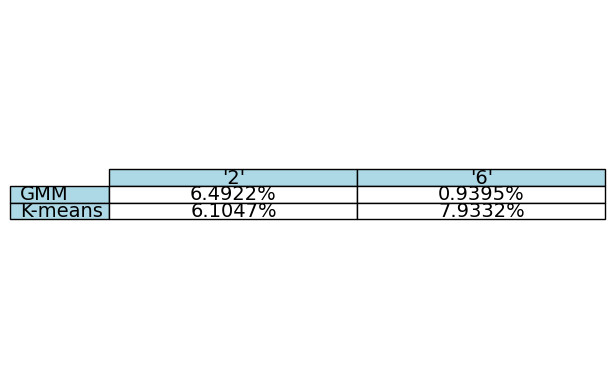

In [12]:

# Misclassification rate for GMM
label_em = np.argmax(r, axis=1)
label_em[label_em == 1] = 2
label_em[label_em == 0] = 6

conf_matrix_em = confusion_matrix(label, label_em)
misclassification_rate_2_em = 1 - accuracy_score(label[label == 2], label_em[label == 2])
misclassification_rate_6_em = 1 - accuracy_score(label[label == 6], label_em[label == 6])

# K-means clustering
kmeans = KMeans(n_clusters=2).fit(pdata)
label_kmeans = kmeans.labels_
label_kmeans[label_kmeans == 0] = 2
label_kmeans[label_kmeans == 1] = 6

conf_matrix_kmeans = confusion_matrix(label, label_kmeans)
misclassification_rate_2_kmeans = 1 - accuracy_score(label[label == 2], label_kmeans[label == 2])
misclassification_rate_6_kmeans = 1 - accuracy_score(label[label == 6], label_kmeans[label == 6])

# Create DataFrame with results
results = pd.DataFrame({
    "'2'": [f"{misclassification_rate_2_em:.4%}", f"{misclassification_rate_2_kmeans:.4%}"],
    "'6'": [f"{misclassification_rate_6_em:.4%}", f"{misclassification_rate_6_kmeans:.4%}"]
}, index=['GMM', 'K-means'])

print(results)

# Plotting the table for visual representation
fig, ax = plt.subplots()
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=results.values, colLabels=results.columns, rowLabels=results.index, cellLoc='center', loc='center', colColours=['lightblue']*results.shape[1], rowColours=['lightblue']*results.shape[0])
table.auto_set_font_size(False)
table.set_fontsize(14)
plt.show()


# Question 3


## Question 3.1


In [13]:
import numpy as np

In [14]:
# Vocabulary
vocabulary = ["secret", "offer", "low", "price", "valued", "customer", "today", "dollar", "million", "sports", "is", "for", "play", "healthy", "pizza"]

# Training data: each message is represented as a feature vector
# Spam Messages (y = 0)
spam_messages = [
    [0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0],  # "million dollar offer for today"
    [1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],  # "secret offer today"
    [2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0]   # "secret is secret"
]

# Non-Spam Messages (y = 1)
non_spam_messages = [
    [0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0],  # "low price for valued customer today"
    [1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0],  # "play secret sports today"
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0],  # "sports is healthy"
    [0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1]   # "low price pizza today"
]

# Convert to numpy arrays for easier manipulation
spam_messages = np.array(spam_messages)
non_spam_messages = np.array(non_spam_messages)

# Calculate class priors
total_messages = len(spam_messages) + len(non_spam_messages)
P_y0 = len(spam_messages) / total_messages
P_y1 = len(non_spam_messages) / total_messages

print(f"P(y=0) = {P_y0:.3f}")
print(f"P(y=1) = {P_y1:.3f}")

P(y=0) = 0.429
P(y=1) = 0.571


## Question 3.2

In [15]:
# Calculate word counts for each class
word_counts_spam = np.sum(spam_messages, axis=0)
word_counts_non_spam = np.sum(non_spam_messages, axis=0)

# Calculate total word counts for normalization
total_counts_spam = np.sum(word_counts_spam)
total_counts_non_spam = np.sum(word_counts_non_spam)

# Calculate maximum likelihood estimates
theta_0 = word_counts_spam / total_counts_spam
theta_1 = word_counts_non_spam / total_counts_non_spam

# Specific estimates for given words
theta_0_1 = theta_0[vocabulary.index("secret")]
theta_0_7 = theta_0[vocabulary.index("today")]
theta_1_1 = theta_1[vocabulary.index("secret")]
theta_1_15 = theta_1[vocabulary.index("pizza")]

print(f"theta_0_1 (secret|spam) = {theta_0_1:.3f}")
print(f"theta_0_7 (today|spam) = {theta_0_7:.3f}")
print(f"theta_1_1 (secret|non-spam) = {theta_1_1:.3f}")
print(f"theta_1_15 (pizza|non-spam) = {theta_1_15:.3f}")


theta_0_1 (secret|spam) = 0.273
theta_0_7 (today|spam) = 0.182
theta_1_1 (secret|non-spam) = 0.059
theta_1_15 (pizza|non-spam) = 0.059


## Question 3.3

In [16]:
# Test message "today is secret"
test_message = [0] * len(vocabulary)
test_message[vocabulary.index("today")] = 1
test_message[vocabulary.index("is")] = 1
test_message[vocabulary.index("secret")] = 1

# Calculate posterior probabilities
log_prob_spam = np.log(P_y0)
log_prob_non_spam = np.log(P_y1)

for i in range(len(vocabulary)):
    if test_message[i] > 0:
        log_prob_spam += test_message[i] * np.log(theta_0[i])
        log_prob_non_spam += test_message[i] * np.log(theta_1[i])

# Convert log-probabilities back to normal scale
prob_spam = np.exp(log_prob_spam)
prob_non_spam = np.exp(log_prob_non_spam)

# Normalize probabilities
total_prob = prob_spam + prob_non_spam
posterior_spam = prob_spam / total_prob
posterior_non_spam = prob_non_spam / total_prob

print(f"Posterior probability of spam: {posterior_spam:.3f}")
print(f"Posterior probability of non-spam: {posterior_non_spam:.3f}")

if posterior_spam > posterior_non_spam:
    print("The message 'today is secret' is classified as SPAM.")
else:
    print("The message 'today is secret' is classified as NOT SPAM.")


Posterior probability of spam: 0.847
Posterior probability of non-spam: 0.153
The message 'today is secret' is classified as SPAM.


# Question 4


## Question 4.1

In [17]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier

In [18]:
# Load and prepare the data
data = pd.read_csv("data/marriage.csv", header=None)

# Separate features and target variable
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=194)

# Ensure data is contiguous in memory
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Train and evaluate classifiers
models = {
    'Naive Bayes': GaussianNB(var_smoothing=1e-3),
    'Logistic Regressor': LogisticRegression(max_iter=10000),
    'KNN': KNeighborsClassifier()
}

results = []

for name, model in models.items():
    model.fit(X_train, y_train)
    training_accuracy = model.score(X_train, y_train) * 100
    testing_accuracy = model.score(X_test, y_test) * 100
    results.append({
        'Model Name': name,
        'Training Accuracy': training_accuracy,
        'Testing Accuracy': testing_accuracy
    })

results_df = pd.DataFrame(results)
print(results_df)


           Model Name  Training Accuracy  Testing Accuracy
0         Naive Bayes          98.529412         94.117647
1  Logistic Regressor         100.000000         91.176471
2                 KNN          98.529412         94.117647


## Question 4.2

In [19]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

Naive Bayes (PCA) training accuracy: 98.53%
Naive Bayes (PCA) testing accuracy: 94.12%
------------------------------------------------------------------------
Logistic Regressor (PCA) training accuracy: 99.26%
Logistic Regressor (PCA) testing accuracy: 100.00%
------------------------------------------------------------------------
KNN (PCA) training accuracy: 98.53%
KNN (PCA) testing accuracy: 94.12%
------------------------------------------------------------------------


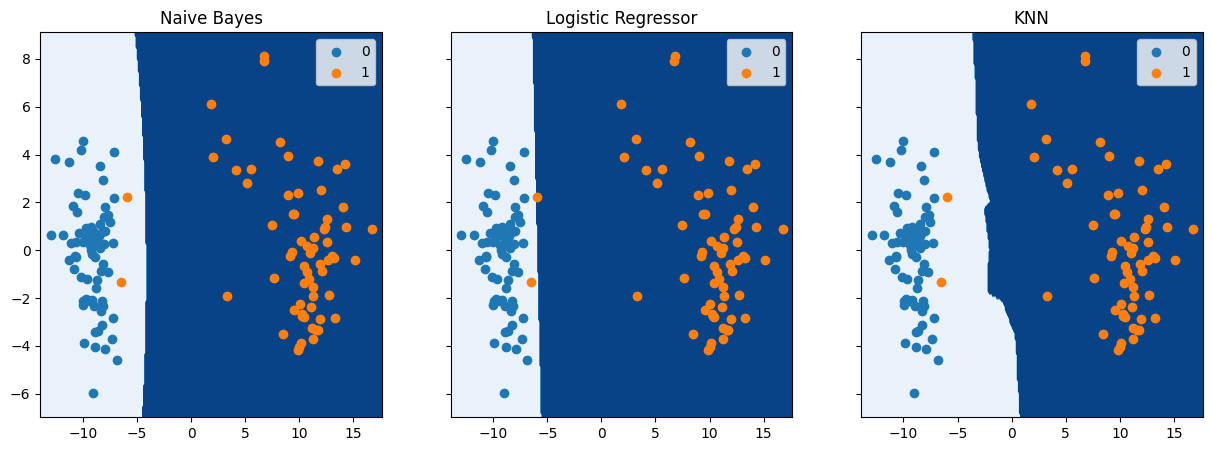

In [20]:

# Load and prepare the data
data = pd.read_csv("data/marriage.csv", header=None)

# Separate features and target variable
X = data.iloc[:, :-1]
y = data.iloc[:, -1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=194)

# Ensure data is contiguous in memory
X_train = np.ascontiguousarray(X_train)
X_test = np.ascontiguousarray(X_test)

# Perform PCA and transform data
pca = PCA(n_components=2)
X_train_pca = pca.fit_transform(X_train)
X_test_pca = pca.transform(X_test)

# Ensure PCA-transformed data is contiguous in memory
X_train_pca = np.ascontiguousarray(X_train_pca)
X_test_pca = np.ascontiguousarray(X_test_pca)

# Define the mesh grid
x_min, x_max = X_train_pca[:, 0].min() - 1, X_train_pca[:, 0].max() + 1
y_min, y_max = X_train_pca[:, 1].min() - 1, X_train_pca[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

# Plot decision boundaries
models = {
    'Naive Bayes': GaussianNB(var_smoothing=1e-3),
    'Logistic Regressor': LogisticRegression(max_iter=10000),
    'KNN': KNeighborsClassifier()
}

f, pl = plt.subplots(1, 3, sharex='col', sharey='row', figsize=(15, 5))

for i, (name, model) in enumerate(models.items()):
    model.fit(X_train_pca, y_train)
    print(f'{name} (PCA) training accuracy: {model.score(X_train_pca, y_train) * 100:.2f}%')
    print(f'{name} (PCA) testing accuracy: {model.score(X_test_pca, y_test) * 100:.2f}%')
    print('------------------------------------------------------------------------')
    
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    pl[i].contourf(xx, yy, Z, cmap='Blues')
    
    for j in range(2):
        pl[i].scatter(X_train_pca[y_train == j, 0], X_train_pca[y_train == j, 1], label=str(j))
        
    pl[i].legend()
    pl[i].set_title(name)

plt.show()
